In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

from visual_bars import generate_visual_bars_data as vbd
from cfl.dataset import Dataset
from cfl.visualization_methods import clustering_to_sankey as sk

from cfl.cluster_methods.snn_helper import SNN as espin_SNN

import cProfile

In [2]:
def graph_clusters(X, labels, plt_title):
    """graphs a 2D scatter plot, colored by cluster labels
    Modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

    Parameters:
        X: an n-length array of 2D points
        labels: an n-length array of labels for the points in X
        plt_title: string, to be displayed as the title of the graph
    """
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=8)

    plt.xlabel('X Units')
    plt.ylabel('Y Units')
    plt.title(plt_title)
    plt.show()

# Simple Gaussian Data

Using data from the original repository 

In [3]:
# create some of the data from the paper 
# blobs
n_samples = 5000
random_state = 170
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

x, y = blobs

# normalize dataset for easier parameter selection
# ^TODO: note this, add it into pipeline
X = StandardScaler().fit_transform(x)

# algorithms
dbscan = cluster.DBSCAN(eps=0.18)
snn = espin_SNN(neighbor_num=20, min_shared_neighbor_proportion=0.5, eps=0.5)


# # do the fitting
# dbscan.fit(X)
# snn.fit(X)

In [4]:
dbscan_labels = dbscan.labels_

graph_clusters(X, dbscan_labels, 'DBSCAN Clustering results')

AttributeError: 'DBSCAN' object has no attribute 'labels_'

In [7]:
cProfile.run('snn.fit(X, 1)', sort='tottime')

         174986485 function calls (174986474 primitive calls) in 344.607 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 24995012  138.650    0.000  138.650    0.000 {method 'reduce' of 'numpy.ufunc' objects}
 12497500   60.621    0.000  126.235    0.000 snn_helper.py:115(get_snn_similarity)
 12497500   55.879    0.000  317.393    0.000 snn_helper.py:129(get_snn_distance_dot)
        1   19.654   19.654  344.567  344.567 snn_helper.py:39(snn)
 12497507   15.758    0.000  105.044    0.000 fromnumeric.py:70(_wrapreduction)
 12497506   13.595    0.000  120.646    0.000 fromnumeric.py:2105(sum)
 12497506    7.639    0.000  135.438    0.000 <__array_function__ internals>:2(sum)
        1    7.070    7.070    7.070    7.070 {method 'tofile' of 'numpy.ndarray' objects}
 12497507    5.578    0.000    5.578    0.000 fromnumeric.py:71(<dictcomp>)
12502520/12502518    5.577    0.000  133.295    0.000 {built-in method numpy.core._mult

In [11]:
new = np.load('d_mat_vect_2.npy')
og = np.load('d_mat_og_2.npy')
np.all(new==og)

True

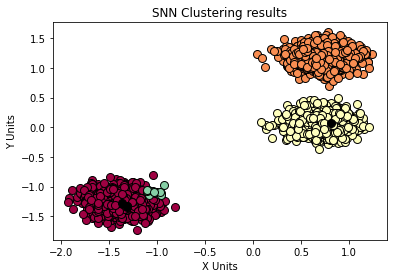

In [12]:
snn_labels = snn.labels_
graph_clusters(X, snn_labels, 'SNN Clustering results')

In [13]:
snn.labels_.shape

(5000,)

In [16]:
# it look like the basic SNN code is working in a reasonable way for most of the data 
# but i'm confused about that black point in the middle of the green cluster 

# the black point is a result of the parameter values but i'm still not totally understainding it

In [36]:
# that one point is the only noise point 
np.sum(snn_labels==-1)

1

In [41]:
X[snn_labels==-1]

array([[-1.49965062, -1.34026228]])

In [8]:
# select only the points in the green cluster 
greenX = X[X[:, 0] < -0.5]

distance matrix saved


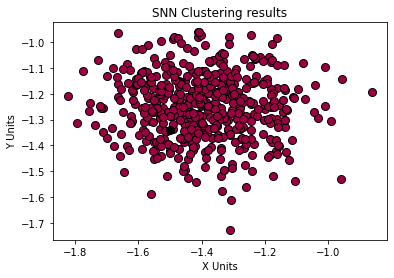

In [11]:
# cluster just those points
snn = espin_SNN(neighbor_num=20, min_shared_neighbor_proportion=0.5)
snn.fit(greenX)
snn_labels = snn.labels_
graph_clusters(greenX, snn_labels, 'SNN Clustering results')

distance matrix saved


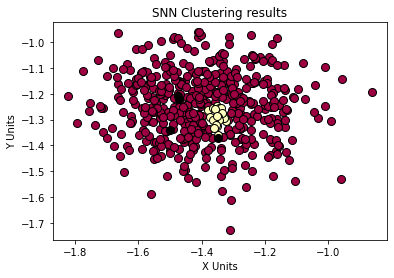

In [12]:
# cluster just those points
snn = espin_SNN(neighbor_num=20, min_shared_neighbor_proportion=0.68)
snn.fit(greenX)
snn_labels = snn.labels_
graph_clusters(greenX, snn_labels, 'SNN Clustering results')

In [72]:
np.unique(snn_labels)

array([-1,  0], dtype=int64)

In [ ]:
# varying the min_shared_neighbor_proportion, i see that this noise point occurs when the value is >0.47 and <=0.67 (above 0.67, the clusters change more )
# (neighbor_num fixed at 20)

In [54]:
# the index of the noise point is 410 out of 500 - kind of in the middle 
np.where(greenX == greenX[snn_labels==-1])
greenX[410]

array([-1.49965062, -1.34026228])

distance matrix saved


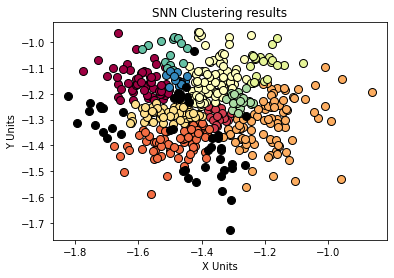

In [13]:
# cluster just those points
snn = espin_SNN(neighbor_num=20, min_shared_neighbor_proportion=0.8)
snn.fit(greenX)
snn_labels = snn.labels_
graph_clusters(greenX, snn_labels, 'SNN Clustering results')

## How do the parameters affect the behavior of the function? 

# Using the CFL interface for SNN clustering

In [55]:
# now we will check that the additions to the code for CFL work 

In [56]:
from cfl.cluster_methods.snn import SNN


# create some of the data from the paper 
# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5],  random_state=random_state)

x, y = varied

# normalize dataset for easier parameter selection
# ^TODO: note this, add it into pipeline
X = StandardScaler().fit_transform(X)

# algorithms
data_info = {'X_dims': X.shape,
             'Y_dims': X.shape,
             'Y_type': 'continuous'}

In [57]:
X.shape

(750, 2)

In [59]:
cluster_params = {'neighbor_num': 20, 'min_shared_neighbor_proportion' : 0.5 }

snn_obj = SNN('SNN', data_info, cluster_params, random_state=143)

res = snn_obj.train(Dataset(X, X), prev_results=X)

##TODO: why are all the warnings showing up? 

name specified but not used by SNN
[[0.  1.  1.  ... 1.  1.  1. ]
 [1.  0.  1.  ... 1.  1.  1. ]
 [1.  1.  0.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 0.  1.  0.5]
 [1.  1.  1.  ... 1.  0.  1. ]
 [1.  1.  1.  ... 0.5 1.  0. ]]
[[0.  1.  1.  ... 1.  1.  1. ]
 [1.  0.  1.  ... 1.  1.  1. ]
 [1.  1.  0.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 0.  1.  0.5]
 [1.  1.  1.  ... 1.  0.  1. ]
 [1.  1.  1.  ... 0.5 1.  0. ]]


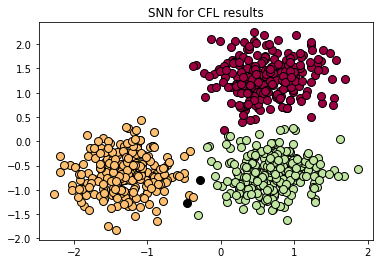

In [61]:
graph_clusters(X, res[0], "SNN for CFL results")

In [ ]:
# yay! looks the same as the regular!

In [64]:
X.shape

(750, 2)

## 1-D data

In [ ]:
# create some of the data from the paper 
# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5],  random_state=random_state)

x, y = varied

# normalize dataset for easier parameter selection
# ^TODO: note this, add it into pipeline
X = StandardScaler().fit_transform(X)

# algorithms
data_info = {'X_dims': X[:, 0].shape,
             'Y_dims': X[:, 1].shape,
             'Y_type': 'continuous'}

In [72]:
cluster_params = {'neighbor_num': 20, 'min_shared_neighbor_proportion' : 0.5 }

snn_obj = SNN('SNN', data_info, cluster_params, random_state=143)

res = snn_obj.train(Dataset(X[:, 0], X[:, 1]), prev_results=X[:, 1])

##TODO: doesn't work - why?  

name specified but not used by SNN
[[0.  1.  1.  ... 1.  1.  1. ]
 [1.  0.  1.  ... 1.  1.  1. ]
 [1.  1.  0.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 0.  1.  0.5]
 [1.  1.  1.  ... 1.  0.  1. ]
 [1.  1.  1.  ... 0.5 1.  0. ]]


AxisError: axis 1 is out of bounds for array of dimension 1

# Visual Bars Data 

In [29]:
# create a visual bars data set

n_samples = 100 #100 is too small to get good estimates from the CNN
# but it's too big to cluster in a reasonable time with SNN 

noise_lvl = 0.03
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data.getImages()
y = vb_data.getTarget()

# format data
x = np.expand_dims(ims, -1)

y = one_hot_encode(y, unique_labels=[0,1])



Generating a visual bars dataset with 100 samples at noise level 0.03


In [30]:
x.shape[1:]

(10, 10, 1)

In [32]:
data_info = {'X_dims': x.shape,
             'Y_dims': y.shape,
             'Y_type': 'categorical'}

# # # paragmeters for CDE
# CNN_params = { # parameters for model creation
#                     'filters'         : [32, 16],
#                     'input_shape'     : (10, 10, 1),
#                     'kernel_size'     : [(3, 3)] *2,
#                     'pool_size'       : [(2, 2)] *2,
#                     'padding'         : ['same'] *2,
#                     'conv_activation' : ['softmax', 'softmax'],
#                     'dense_units'     : 16,
#                     'dense_activation' : 'softmax',
#                     'output_activation': 'softmax',

#                     # parameters for training
#                     'batch_size'  : 32,
#                     'n_epochs'    : 5,
#                     'optimizer'   : 'adam',
#                     'opt_config'  : {},
#                     'verbose'     : 2,
#                     'weights_path': None,
#                     'loss'        : 'mean_squared_error',
#                     'show_plot'   : True,
#                     'standardize' : False,
#                     'best'        : True,
#                     }


# block_names = ['CondExpCNN']
# block_params = [CNN_params]

# # save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
# save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test'
# my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

# results = my_exp.train()

In [33]:
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, results_path=save_path, past_exp_path='C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050')
import joblib 

results = joblib.load('C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050/dataset_train/CondExpCNN_results.pickle')

my_exp.blocks[0].model.summary()

All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test\experiment0062
Loading parameters from  C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050\trained_blocks\CondExpCNN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
______________________

In [34]:
pyx = results['pyx']

pyx[:10]

array([[0.4856626 , 0.5143374 ],
       [0.48567176, 0.51432824],
       [0.48563722, 0.5143628 ],
       [0.48567256, 0.5143274 ],
       [0.4856798 , 0.51432014],
       [0.48568168, 0.51431835],
       [0.48565772, 0.5143423 ],
       [0.48565605, 0.514344  ],
       [0.4856683 , 0.51433164],
       [0.48566756, 0.5143325 ]], dtype=float32)

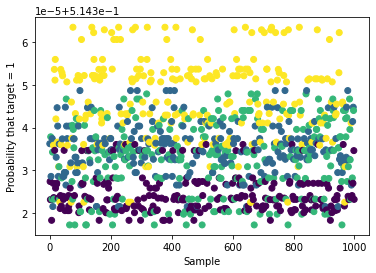

Average prediction for x-class 0: 0.49
Average prediction for x-class 1: 0.49
Average prediction for x-class 2: 0.49
Average prediction for x-class 3: 0.49


In [35]:
truth = vb_data.getGroundTruth()

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace= True)

# plot them
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,0])))


In [36]:
from cfl.cluster_methods.snn import SNN

cluster_params = {'neighbor_num': 20, 'min_shared_neighbor_proportion' : 0.5 }
snn_obj = SNN('SNN', data_info, cluster_params, random_state=143)

cde_results_dict = results

data = Dataset(x, y)

cProfile.run('snn_obj.train(data, cde_results_dict["pyx"])', sort='tottime')




name specified but not used by SNN
[[0.   1.   1.   ... 1.   1.   0.85]
 [1.   0.   1.   ... 0.1  1.   1.  ]
 [1.   1.   0.   ... 1.   0.05 0.65]
 ...
 [1.   0.1  1.   ... 0.   1.   1.  ]
 [1.   1.   0.05 ... 1.   0.   0.65]
 [0.85 1.   0.65 ... 1.   0.65 0.  ]]
[[0.   1.   1.   ... 0.05 1.   1.  ]
 [1.   0.   0.05 ... 1.   0.05 0.05]
 [1.   0.05 0.   ... 1.   0.   0.05]
 ...
 [0.05 1.   1.   ... 0.   1.   1.  ]
 [1.   0.05 0.   ... 1.   0.   0.05]
 [1.   0.05 0.05 ... 1.   0.05 0.  ]]
         93870 function calls (93752 primitive calls) in 0.090 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.012    0.006    0.088    0.044 snn_helper.py:35(snn)
     9900    0.008    0.000    0.008    0.000 {method 'intersection' of 'set' objects}
     9900    0.007    0.000    0.016    0.000 snn_helper.py:74(get_snn_distance)
      929    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     3958 

In [37]:
res = snn_obj.train(data, cde_results_dict["pyx"])

[[0.   1.   1.   ... 1.   1.   0.85]
 [1.   0.   1.   ... 0.1  1.   1.  ]
 [1.   1.   0.   ... 1.   0.05 0.65]
 ...
 [1.   0.1  1.   ... 0.   1.   1.  ]
 [1.   1.   0.05 ... 1.   0.   0.65]
 [0.85 1.   0.65 ... 1.   0.65 0.  ]]
[[0.   1.   1.   ... 0.05 1.   1.  ]
 [1.   0.   0.05 ... 1.   0.05 0.05]
 [1.   0.05 0.   ... 1.   0.   0.05]
 ...
 [0.05 1.   1.   ... 0.   1.   1.  ]
 [1.   0.05 0.   ... 1.   0.   0.05]
 [1.   0.05 0.05 ... 1.   0.05 0.  ]]


In [38]:
compare = joblib.load('compare.pkl')

In [39]:
res[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [41]:
compare[0]

array([[0. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 0. , 1. , ..., 0.5, 1. , 1. ],
       [1. , 1. , 0. , ..., 1. , 1. , 1. ],
       ...,
       [1. , 0.5, 1. , ..., 0. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 0. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 0. ]])

In [43]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(truth, res[0])


0.0

In [53]:
# create a number of Kmeans objects with different Ks
k_range = range(2, 8)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2}
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss
x_lbls_L = []
for kmeans_obj in kmeans_l:
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])


In [56]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])

fig.update_layout(title_text="Visual Bars Clustering, noise=0.03, with 2 to 7 Clusters", font_size=10)
fig.show()

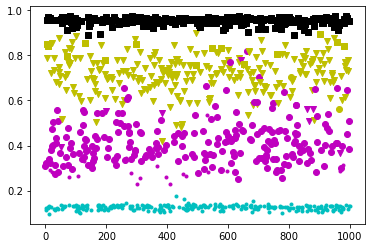

In [77]:
truth = vb_data.getGroundTruth()

# graph the 4 actual clusters against 4 predicted clusters 

# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[2][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.show()



In [ ]:
from cfl.visualization_methods import general_vis as vis

vis.view_class_examples(ims, im_shape, 10, x_lbls_L[0])


In [ ]:
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[1])


# # %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[2])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[3])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[4])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[5])



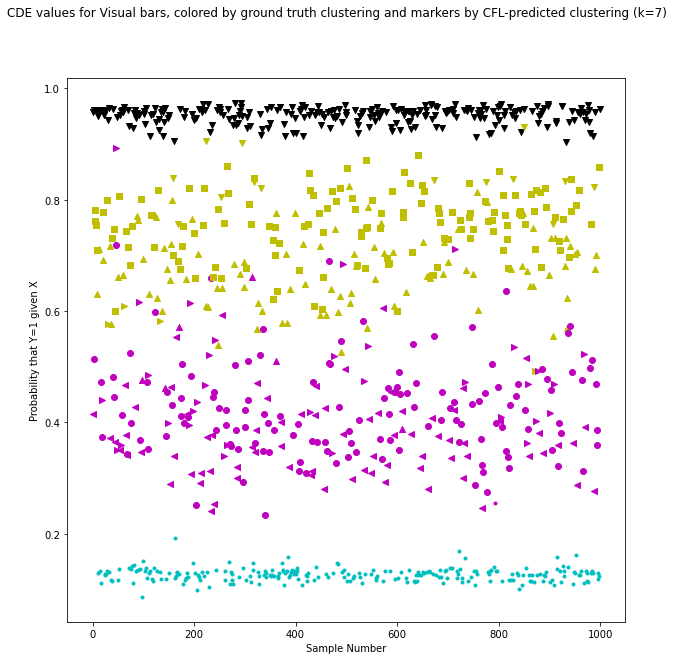

In [82]:
truth = vb_data.getGroundTruth()


# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']


#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
fig = plt.figure(figsize=(10, 10))
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[5][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.xlabel("Sample Number")
plt.ylabel("Probability that Y=1 given X")
plt.suptitle('CDE values for Visual bars, colored by ground truth clustering and markers by CFL-predicted clustering (k=7)')
plt.show()
